In [1]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
# from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

In [2]:
import gc
import os

gc.collect()
torch.cuda.empty_cache()

In [3]:
# 시드 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True

# 데이터 전처리

In [4]:
class MakeDataset():
    def __init__(self, DATA_PATH):
        self.fe(DATA_PATH)
        self.user_data = self.k_fold()
    
    def k_fold(self):
        users = self.train_test_df['userID'].unique().tolist() # userID 기준 split
        user_data = {}
        kf = KFold(n_splits = 5, random_state = 42, shuffle = True) # 8:2 split
        for idx, (train_idx, valid_idx) in enumerate(kf.split(users)):
            user_data[idx] = valid_idx.tolist()
        
        return user_data

    def fe(self, DATA_PATH):
        train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), parse_dates=['Timestamp'])
        #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
        train_df.sort_values(by=['userID','Timestamp'], inplace=True)

        test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), parse_dates=['Timestamp'])
        #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
        test_df.sort_values(by=['userID','Timestamp'], inplace=True)

        # 시험지 번호
        train_df['assessNum'] = train_df['assessmentItemID'].apply(lambda x:int(x[1:3]))
        test_df['assessNum'] = test_df['assessmentItemID'].apply(lambda x:int(x[1:3]))

        # 시험지 내 문항번호
        train_df['problemNum'] = train_df['assessmentItemID'].apply(lambda x:int(x[3:]))
        test_df['problemNum'] = test_df['assessmentItemID'].apply(lambda x:int(x[3:]))

        # 문제 푸는데 걸린 시간
        def time_diff(df):
            df['time'] = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().shift(-1)
            df['time'] = df['time'].fillna(df['time'].median())                        # Null값은 중앙값으로 채우기.
            df['time'] = df['time'].apply(lambda x:x.total_seconds())                  # 년,월,일,날짜로 되어있는 값을 시간초로 변환
            df['time'] = df['time'].apply(lambda x:300 if x > 300 else x)              # 최댓값을 300으로 변환.
            df['time'] = df['time']
            return df
        train_df = time_diff(train_df)
        test_df = time_diff(test_df)
        
        # train data + test data 사용
        train_test_df = pd.concat([train_df, test_df])
        train_test_df = train_test_df[train_test_df['answerCode'] != -1].reset_index(drop = True)

        # 문제를 푼 시간
        train_df['hour'] = train_df['Timestamp'].dt.hour
        test_df['hour'] = test_df['Timestamp'].dt.hour

        # 문제를 푼 요일 # Monday ~ Sunday => 0 ~ 6
        train_df['wday'] = train_df['Timestamp'].dt.weekday
        test_df['wday'] = test_df['Timestamp'].dt.weekday
        
        
        # index 로 변환
        def emb_idx(emb_list) -> dict:
            embidx = {}
            for idx, i in enumerate(emb_list):
                embidx[i] = idx
            return embidx

        # 범주형 변수 -> embedding 추가
        assessmentItemID2idx = emb_idx(train_test_df['assessmentItemID'].unique().tolist())
        testId2idx = emb_idx(train_test_df['testId'].unique().tolist())
        KnowledgeTag2idx = emb_idx(train_test_df['KnowledgeTag'].unique().tolist())
        problemNum2idx = emb_idx(train_test_df['problemNum'].unique().tolist())
        assessNum2idx = emb_idx(train_test_df['assessNum'].unique().tolist())

        train_df['assessmentItemID2idx'] = train_df['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
        train_df['testId2idx'] = train_df['testId'].apply(lambda x : testId2idx[x])
        train_df['KnowledgeTag2idx'] = train_df['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
        train_df['problemNum2idx'] = train_df['problemNum'].apply(lambda x : problemNum2idx[x])
        train_df['assessNum2idx'] = train_df['assessNum'].apply(lambda x : assessNum2idx[x])

        test_df['assessmentItemID2idx'] = test_df['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
        test_df['testId2idx'] = test_df['testId'].apply(lambda x : testId2idx[x])
        test_df['KnowledgeTag2idx'] = test_df['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
        test_df['problemNum2idx'] = test_df['problemNum'].apply(lambda x : problemNum2idx[x])
        test_df['assessNum2idx'] = test_df['assessNum'].apply(lambda x : assessNum2idx[x])

        self.assessmentItemID2idx = assessmentItemID2idx
        self.train_df = train_df
        self.test_df = test_df
        self.train_test_df = pd.concat([train_df, test_df[test_df['answerCode'] != -1]]).reset_index(drop=True)
        self.num_assessmentItemID = len(assessmentItemID2idx)
        self.num_testId = len(testId2idx)
        self.num_KnowledgeTag = len(KnowledgeTag2idx)
        self.num_problemNum = len(problemNum2idx)
        self.num_assessNum = len(assessNum2idx)
        self.num_hour = 24
        self.num_wday = 7
        
        print("train_shape", train_df.shape)
        print("test_shape", test_df.shape)
        print("train_test", train_test_df.shape)

    # train, valid 데이터 생성
    def train_valid_split(self, kf):
        val_users = self.user_data[kf]
        train = []
        valid = []

        user_df = self.train_test_df.groupby('userID')

        for userID, df in user_df:
            if userID in val_users:
                train_df_2 = df.iloc[:-1, :]
                valid_df_2 = df.copy()
                train.append(train_df_2)
                valid.append(valid_df_2)
            else:
                train.append(df)

        train = pd.concat(train).reset_index(drop = True)
        valid = pd.concat(valid).reset_index(drop = True)
        
        print("train_shape", train.shape)
        print("validt_shape", valid.shape)
        
        return train, valid
    
    # test 데이터 생성
    def get_test_data(self):
        print("test_shape", self.test_df.shape)
        return self.test_df.copy()

In [5]:
class CustomDataset(Dataset):
    def __init__(
        self,
        df,
        cat_cols = ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 
                    'assessNum2idx', 'hour', 'wday'],
        num_cols = ['time'],
        max_len = None,
        window = None,
        data_augmentation = False,
        ):

        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.get_df = df.groupby('userID')
        self.user_list = df['userID'].unique().tolist()
        self.max_len = max_len
        self.window = window
        self.data_augmentation = data_augmentation
        if self.data_augmentation:
            self.cat_feature_list, self.num_feature_list, self.answerCode_list = self._data_augmentation()

        print("cat, num", cat_cols, num_cols)

    def __len__(self):
        if self.data_augmentation:
            return len(self.cat_feature_list)
        return len(self.user_list)

    def __getitem__(self, idx):
        if self.data_augmentation:
            cat_feature = self.cat_feature_list[idx]
            num_feature = self.num_feature_list[idx]
            answerCode = self.answerCode_list[idx]

            now_cat_feature = cat_feature[1:, :]
            now_num_feature = num_feature[1:, :]
            now_answerCode = answerCode[1:]
            
            past_cat_feature = cat_feature[:-1, :]
            past_num_feature = num_feature[:-1, :]
            past_answerCode = answerCode[:-1]
            
        else:
            user = self.user_list[idx]
            if self.max_len:
                get_df = self.get_df.get_group(user).iloc[-self.max_len:, :]
            else:
                get_df = self.get_df.get_group(user)

            now_df = get_df.iloc[1:, :]
            now_cat_feature = now_df[self.cat_cols].values
            now_num_feature = now_df[self.num_cols].values
            now_answerCode = now_df['answerCode'].values

            past_df = get_df.iloc[:-1, :]
            past_cat_feature = past_df[self.cat_cols].values
            past_num_feature = past_df[self.num_cols].values
            past_answerCode = past_df['answerCode'].values

        return {
            'past_cat_feature' : past_cat_feature, 
            'past_num_feature' : past_num_feature, 
            'past_answerCode' : past_answerCode, 
            'now_cat_feature' : now_cat_feature, 
            'now_num_feature' : now_num_feature, 
            'now_answerCode' : now_answerCode
            }
    

    def _data_augmentation(self):
        cat_feature_list = []
        num_feature_list = []
        answerCode_list = []
        for userID, get_df in tqdm(self.get_df):
            cat_feature = get_df[self.cat_cols].values[::-1]
            num_feature = get_df[self.num_cols].values[::-1]
            answerCode = get_df['answerCode'].values[::-1]

            start_idx = 0

            if len(get_df) <= self.max_len:
                cat_feature_list.append(cat_feature[::-1])
                num_feature_list.append(num_feature[::-1])
                answerCode_list.append(answerCode[::-1])
            else:
                while True:
                    if len(cat_feature[start_idx: start_idx + self.max_len, :]) < self.max_len:
                        cat_feature_list.append(cat_feature[start_idx: start_idx + self.max_len, :][::-1])
                        num_feature_list.append(num_feature[start_idx: start_idx + self.max_len, :][::-1])
                        answerCode_list.append(answerCode[start_idx: start_idx + self.max_len][::-1])
                        break
                    cat_feature_list.append(cat_feature[start_idx: start_idx + self.max_len, :][::-1])
                    num_feature_list.append(num_feature[start_idx: start_idx + self.max_len, :][::-1])
                    answerCode_list.append(answerCode[start_idx: start_idx + self.max_len][::-1])
                    start_idx += self.window
            
        return cat_feature_list, num_feature_list, answerCode_list

In [6]:
def pad_sequence(seq, max_len, padding_value = 0):
    try:
        seq_len, col = seq.shape
        padding = np.zeros((max_len - seq_len, col)) + padding_value
    except:
        seq_len = seq.shape[0]
        padding = np.zeros((max_len - seq_len, )) + padding_value

    padding_seq = np.concatenate([padding, seq])

    return padding_seq

def train_make_batch(samples):
    max_len = 0
    for sample in samples:
        seq_len, col = sample['past_cat_feature'].shape
        if max_len < seq_len:
            max_len = seq_len
    
    past_cat_feature = []
    past_num_feature = []
    past_answerCode = []
    now_cat_feature = []
    now_num_feature = []
    now_answerCode = []

    for sample in samples:
        past_cat_feature += [pad_sequence(sample['past_cat_feature'] + 1, max_len = max_len, padding_value = 0)]
        past_num_feature += [pad_sequence(sample['past_num_feature'], max_len = max_len, padding_value = 0)]
        past_answerCode += [pad_sequence(sample['past_answerCode'] + 1, max_len = max_len, padding_value = 0)]
        now_cat_feature += [pad_sequence(sample['now_cat_feature'] + 1, max_len = max_len, padding_value = 0)]
        now_num_feature += [pad_sequence(sample['now_num_feature'], max_len = max_len, padding_value = 0)]
        now_answerCode += [pad_sequence(sample['now_answerCode'], max_len = max_len, padding_value = -1)]

    return torch.tensor(past_cat_feature, dtype = torch.long), torch.tensor(past_num_feature, dtype = torch.float32), torch.tensor(past_answerCode, dtype = torch.long), torch.tensor(now_cat_feature, dtype = torch.long), torch.tensor(now_num_feature, dtype = torch.float32), torch.tensor(now_answerCode, dtype = torch.float32)

## Model

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, model_dim, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.model_dim = model_dim
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, attn_mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, model_dim)
        attn_mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.model_dim) # (batch_size, num_heads, max_len, model_dim)
        # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_score = attn_score.masked_fill(attn_mask == 0, -1e9)
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, model_dim) / # dim of output : batchSize x num_head x seqLen x model_dim
        
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.model_dim = model_dim
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(model_dim, model_dim, bias=False)
        self.W_K = nn.Linear(model_dim, model_dim, bias=False)
        self.W_V = nn.Linear(model_dim, model_dim, bias=False)
        self.W_O = nn.Linear(model_dim, model_dim, bias=False)

        self.attention = ScaledDotProductAttention(model_dim, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(model_dim, 1e-6) # layer normalization

    def forward(self, enc, attn_mask):
        """
        enc : (batch_size, max_len, model_dim)
        attn_mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.model_dim // self.num_heads) # (batch_size, max_len, num_heads, model_dim)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.model_dim // self.num_heads) # (batch_size, max_len, num_heads, model_dim)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.model_dim // self.num_heads) # (batch_size, max_len, num_heads, model_dim)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, model_dim)
        output, attn_dist = self.attention(Q, K, V, attn_mask) # output : (batch_size, num_heads, max_len, model_dim) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, model_dim) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, model_dim * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, model_dim)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, model_dim, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()
        self.W_1 = nn.Linear(model_dim, model_dim)
        self.W_2 = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(model_dim, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class SASRecEncoder(nn.Module):
    def __init__(self, num_heads, model_dim, dropout_rate):
        super(SASRecEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads, model_dim, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(model_dim, dropout_rate)

    def forward(self, input_enc, attn_mask):
        """
        input_enc : (batch_size, max_len, model_dim)
        attn_mask : (batch_size, 1, max_len, max_len)
        """
        output_enc, attn_dist = self.attention(input_enc, attn_mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class SASRec(nn.Module):
    def __init__(
        self, 
        num_assessmentItemID, 
        num_testId,
        num_KnowledgeTag,
        num_problemNum,
        num_assessNum,
        num_hour,
        num_wday,
        num_cols,
        cat_cols,
        emb_size,
        model_dim,
        num_heads, 
        num_layers, 
        dropout_rate, 
        device):
        super(SASRec, self).__init__()
        
        # 과거 정보
        self.past_assessmentItemID_emb = nn.Embedding(num_assessmentItemID + 1, emb_size, padding_idx = 0)
        self.past_testId_emb = nn.Embedding(num_testId + 1, emb_size, padding_idx = 0)
        self.past_KnowledgeTag_emb = nn.Embedding(num_KnowledgeTag + 1, emb_size, padding_idx = 0)
        self.past_problemNum_emb = nn.Embedding(num_problemNum + 1, emb_size, padding_idx = 0)
        self.past_assessNum_emb = nn.Embedding(num_assessNum + 1, emb_size, padding_idx = 0)
        self.past_hour_emb = nn.Embedding(num_hour + 1, emb_size, padding_idx = 0)
        self.past_wday_emb = nn.Embedding(num_wday + 1, emb_size, padding_idx = 0)
        
        self.past_answerCode_emb = nn.Embedding(3, model_dim, padding_idx = 0)
        self.past_cat_emb = nn.Sequential(
            nn.Linear(len(cat_cols) * emb_size, model_dim // 2),
            nn.LayerNorm(model_dim // 2, eps=1e-6)
        )

        self.past_num_emb = nn.Sequential(
            nn.Linear(len(num_cols), model_dim // 2),
            nn.LayerNorm(model_dim // 2, eps=1e-6)
        )

        self.emb_layernorm = nn.LayerNorm(model_dim, eps=1e-6)

        self.past_lstm = nn.LSTM(
            input_size = model_dim,
            hidden_size = model_dim,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = dropout_rate,
            )

        self.past_blocks = nn.ModuleList([SASRecEncoder(num_heads, model_dim, dropout_rate) for _ in range(num_layers)])        
        
        # 현재 정보 - answerCode X
        self.now_assessmentItemID_emb = nn.Embedding(num_assessmentItemID + 1, emb_size, padding_idx = 0)
        self.now_testId_emb = nn.Embedding(num_testId + 1, emb_size, padding_idx = 0) 
        self.now_KnowledgeTag_emb = nn.Embedding(num_KnowledgeTag + 1, emb_size, padding_idx = 0) 
        self.now_problemNum_emb = nn.Embedding(num_problemNum + 1, emb_size, padding_idx = 0)
        self.now_assessNum_emb = nn.Embedding(num_assessNum + 1, emb_size, padding_idx = 0)
        self.now_hour_emb = nn.Embedding(num_hour + 1, emb_size, padding_idx = 0)
        self.now_wday_emb = nn.Embedding(num_wday + 1, emb_size, padding_idx = 0) 

        self.now_cat_emb = nn.Sequential(
            nn.Linear(len(cat_cols) * emb_size, model_dim // 2),
            nn.LayerNorm(model_dim // 2, eps=1e-6)
        )

        self.now_num_emb = nn.Sequential(
            nn.Linear(len(num_cols), model_dim // 2),
            nn.LayerNorm(model_dim // 2, eps=1e-6)
        )

        self.now_lstm = nn.LSTM(
            input_size = model_dim,
            hidden_size = model_dim,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = dropout_rate,
            )

        self.now_blocks = nn.ModuleList([SASRecEncoder(num_heads, model_dim, dropout_rate) for _ in range(num_layers)])

        # predict
        self.dropout = nn.Dropout(dropout_rate)

        self.predict_layer = nn.Sequential(
            nn.Linear(model_dim * 2, 1),
            nn.Sigmoid()
        )

        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.device = device
    
    
    def forward(self, past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature):
        """
        past_cat_feature : (batch_size, max_len, cat_cols)
        past_num_feature : (batch_size, max_len, num_cols)
        past_answerCode : (batch_size, max_len)

        now_cat_feature : (batch_size, max_len, cat_cols)
        now_num_feature : (batch_size, max_len, num_cols)
        
        """

        past_cat_emb_list = []
        for idx in range(len(self.cat_cols)):
            if self.cat_cols[idx] == 'assessmentItemID2idx':
                past_cat_emb_list.append(self.past_assessmentItemID_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'testId2idx':
                past_cat_emb_list.append(self.past_testId_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'KnowledgeTag2idx':
                past_cat_emb_list.append(self.past_KnowledgeTag_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'problemNum2idx':
                past_cat_emb_list.append(self.past_problemNum_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'assessNum2idx':
                past_cat_emb_list.append(self.past_assessNum_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'hour':
                past_cat_emb_list.append(self.past_hour_emb(past_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'wday':
                past_cat_emb_list.append(self.past_wday_emb(past_cat_feature[:, :, idx]))

        past_cat_emb = torch.concat(past_cat_emb_list, dim = -1)
        past_cat_emb = self.past_cat_emb(past_cat_emb)
        past_num_emb = self.past_num_emb(past_num_feature)

        past_emb = torch.concat([past_cat_emb, past_num_emb], dim = -1)
        past_emb += self.past_answerCode_emb(past_answerCode.to(self.device))
        past_emb = self.emb_layernorm(past_emb) # LayerNorm

        # attn_masking 
        attn_mask_pad = torch.BoolTensor(past_answerCode > 0).unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_len)
        attn_mask_time = (1 - torch.triu(torch.ones((1, 1, past_answerCode.size(1), past_answerCode.size(1))), diagonal=1)).bool() # (batch_size, 1, max_len, max_len)
        attn_mask = (attn_mask_pad & attn_mask_time).to(self.device) # (batch_size, 1, max_len, max_len)
        for block in self.past_blocks:
            past_emb, attn_dist = block(past_emb, attn_mask)

        past_emb, _ = self.past_lstm(past_emb)

        now_cat_emb_list = []
        for idx in range(len(self.cat_cols)):
            if self.cat_cols[idx] == 'assessmentItemID2idx':
                now_cat_emb_list.append(self.now_assessmentItemID_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'testId2idx':
                now_cat_emb_list.append(self.now_testId_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'KnowledgeTag2idx':
                now_cat_emb_list.append(self.now_KnowledgeTag_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'problemNum2idx':
                now_cat_emb_list.append(self.now_problemNum_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'assessNum2idx':
                now_cat_emb_list.append(self.now_assessNum_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'hour':
                now_cat_emb_list.append(self.now_hour_emb(now_cat_feature[:, :, idx]))
            elif self.cat_cols[idx] == 'wday':
                now_cat_emb_list.append(self.now_wday_emb(now_cat_feature[:, :, idx]))
                
        now_cat_emb = torch.concat(now_cat_emb_list, dim = -1)
        now_cat_emb = self.now_cat_emb(now_cat_emb)
        now_num_emb = self.now_num_emb(now_num_feature)

        now_emb = torch.concat([now_cat_emb, now_num_emb], dim = -1)

        for block in self.now_blocks:
            now_emb, attn_dist = block(now_emb, attn_mask)

        now_emb, _ = self.now_lstm(now_emb)

        emb = torch.concat([past_emb, now_emb], dim = -1)
        
        output = self.predict_layer(self.dropout(emb))

        return output

## Trainer

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score

def train(model, data_loader, criterion, optimizer):
    model.train()
    loss_val = 0

    for past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature, now_answerCode in data_loader:

        past_cat_feature, past_num_feature, past_answerCode = past_cat_feature.to(device), past_num_feature.to(device), past_answerCode
        now_cat_feature, now_num_feature, now_answerCode = now_cat_feature.to(device), now_num_feature.to(device), now_answerCode.to(device)

        optimizer.zero_grad()

        output = model(past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature).squeeze(2)
        loss = criterion(output[now_answerCode != -1], now_answerCode[now_answerCode != -1])

        loss.backward()
        optimizer.step()

        loss_val += loss.item()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader):
    model.eval()

    result = []
    pred = []

    with torch.no_grad():
        for past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature, now_answerCode in data_loader:
            past_cat_feature, past_num_feature, past_answerCode = past_cat_feature.to(device), past_num_feature.to(device), past_answerCode
            now_cat_feature, now_num_feature, now_answerCode = now_cat_feature.to(device), now_num_feature.to(device), now_answerCode.to(device)
            
            output = model(past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature).squeeze(2)

            result.extend(now_answerCode[:, -1].cpu().numpy().tolist())
            pred.extend(output[:, -1].cpu().numpy().tolist())

    roc_auc = roc_auc_score(result, pred)
    pred = np.array(pred)
    acc_score = accuracy_score(result, np.where(pred >= 0.5, 1, 0))

    return roc_auc, acc_score


def predict(model, data_loader):
    model.eval()

    pred = []

    with torch.no_grad():
        for past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature, now_answerCode in data_loader:
            past_cat_feature, past_num_feature, past_answerCode = past_cat_feature.to(device), past_num_feature.to(device), past_answerCode
            now_cat_feature, now_num_feature = now_cat_feature.to(device), now_num_feature.to(device)
            
            output = model(past_cat_feature, past_num_feature, past_answerCode, now_cat_feature, now_num_feature).squeeze(2)
            pred.extend(output[:, -1].cpu().numpy().tolist())

    return pred

## Train

In [9]:
batch_size = 8
epochs = 10
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

emb_size = 32
model_dim = 128
num_heads = 4 # 2,4,8,16,32
num_layers = 1
dropout_rate = 0.5
num_workers = 4

max_len = 50
window = 10
data_augmentation = False

DATA_PATH = '/opt/ml/input/data'
MODEL_PATH = '/opt/ml/input/notebooks/model'
OUTPUT_PATH = '/opt/ml/input/notebooks/transformerlstm_output'

model_name = 'baseline_10epoch.pt'
result_file = 'baseline_10epochs.csv'

In [10]:
make_dataset = MakeDataset(DATA_PATH = DATA_PATH)

train_shape (2266586, 16)
test_shape (260114, 16)
train_test (2525956, 9)


In [11]:
roc_auc_sum = 0
accuracy_sum = 0

for kf in make_dataset.user_data.keys():
    train_df, valid_df = make_dataset.train_valid_split(kf)
    
    train_dataset = CustomDataset(df = train_df,)
    train_data_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = train_make_batch,
        num_workers = num_workers)

    valid_dataset = CustomDataset(df = valid_df,)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 1,
        shuffle = False, 
        drop_last = False,
        collate_fn = train_make_batch,
        num_workers = num_workers)

    model = SASRec(
        num_assessmentItemID = make_dataset.num_assessmentItemID, 
        num_testId = make_dataset.num_testId,
        num_KnowledgeTag = make_dataset.num_KnowledgeTag,
        num_problemNum = make_dataset.num_problemNum,
        num_assessNum = make_dataset.num_assessNum,
        num_hour = make_dataset.num_hour,
        num_wday = make_dataset.num_wday,
        num_cols = train_dataset.num_cols,
        cat_cols = train_dataset.cat_cols,
        emb_size = emb_size,
        model_dim = model_dim,
        num_heads = num_heads,
        num_layers = num_layers,
        dropout_rate = dropout_rate,
        device = device).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.BCELoss()
    
    best_epoch = 0
    best_train_loss = 0
    best_roc_auc = 0
    best_acc_score = 0

    for epoch in range(1, epochs + 1):
        tbar = tqdm(range(1))
        for _ in tbar:
            train_loss = train(model = model, data_loader = train_data_loader, criterion = criterion, optimizer = optimizer)
            roc_auc, acc_score = evaluate(model = model, data_loader = valid_data_loader)
            if best_roc_auc < roc_auc:
                best_epoch = epoch
                best_train_loss = train_loss
                best_roc_auc = roc_auc
                best_acc_score = acc_score
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'kf_{kf}_' + model_name))

            tbar.set_description(f'{kf}th| Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| roc_auc: {roc_auc:.5f}| acc: {acc_score:.5f}')
    
    print(f'BEST: {kf}| Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| roc_auc: {best_roc_auc:.5f}| acc: {best_acc_score:.5f}')

    roc_auc_sum += best_roc_auc
    accuracy_sum += best_acc_score

print(f'Total roc_auc: {roc_auc_sum / len(make_dataset.user_data.keys()):.5f}')
print(f'Total accuracy: {accuracy_sum / len(make_dataset.user_data.keys()):.5f}')

train_shape (2524467, 16)
validt_shape (525799, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


0th| Epoch:   1| Train loss: 0.49484| roc_auc: 0.82929| acc: 0.75084: 100%|██████████| 1/1 [01:31<00:00, 91.09s/it]
0th| Epoch:   2| Train loss: 0.45305| roc_auc: 0.84047| acc: 0.76427: 100%|██████████| 1/1 [01:29<00:00, 89.51s/it]
0th| Epoch:   3| Train loss: 0.44424| roc_auc: 0.84674| acc: 0.76293: 100%|██████████| 1/1 [01:32<00:00, 92.62s/it]
0th| Epoch:   4| Train loss: 0.43935| roc_auc: 0.84819| acc: 0.77099: 100%|██████████| 1/1 [01:30<00:00, 90.98s/it]
0th| Epoch:   5| Train loss: 0.43621| roc_auc: 0.85076| acc: 0.77032: 100%|██████████| 1/1 [01:29<00:00, 89.98s/it]
0th| Epoch:   6| Train loss: 0.43343| roc_auc: 0.85206| acc: 0.77300: 100%|██████████| 1/1 [01:31<00:00, 91.49s/it]
0th| Epoch:   7| Train loss: 0.43120| roc_auc: 0.85272| acc: 0.77770: 100%|██████████| 1/1 [01:30<00:00, 90.61s/it]
0th| Epoch:   8| Train loss: 0.42846| roc_auc: 0.85180| acc: 0.77233: 100%|██████████| 1/1 [01:30<00:00, 90.81s/it]
0th| Epoch:   9| Train loss: 0.42664| roc_auc: 0.85639| acc: 0.77569: 10

BEST: 0| Epoch:  10| Train loss: 0.42536| roc_auc: 0.85677| acc: 0.77099
train_shape (2524467, 16)
validt_shape (517127, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


1th| Epoch:   1| Train loss: 0.49262| roc_auc: 0.82239| acc: 0.75285: 100%|██████████| 1/1 [01:30<00:00, 90.54s/it]
1th| Epoch:   2| Train loss: 0.45212| roc_auc: 0.82969| acc: 0.75151: 100%|██████████| 1/1 [01:31<00:00, 91.19s/it]
1th| Epoch:   3| Train loss: 0.44392| roc_auc: 0.83450| acc: 0.75554: 100%|██████████| 1/1 [01:30<00:00, 90.38s/it]
1th| Epoch:   4| Train loss: 0.43888| roc_auc: 0.83634| acc: 0.75823: 100%|██████████| 1/1 [01:30<00:00, 90.37s/it]
1th| Epoch:   5| Train loss: 0.43601| roc_auc: 0.84319| acc: 0.76427: 100%|██████████| 1/1 [01:29<00:00, 89.58s/it]
1th| Epoch:   6| Train loss: 0.43361| roc_auc: 0.84161| acc: 0.75554: 100%|██████████| 1/1 [01:30<00:00, 90.07s/it]
1th| Epoch:   7| Train loss: 0.43127| roc_auc: 0.84268| acc: 0.76293: 100%|██████████| 1/1 [01:30<00:00, 90.19s/it]
1th| Epoch:   8| Train loss: 0.42905| roc_auc: 0.84361| acc: 0.75957: 100%|██████████| 1/1 [01:29<00:00, 89.68s/it]
1th| Epoch:   9| Train loss: 0.42723| roc_auc: 0.84508| acc: 0.75621: 10

BEST: 1| Epoch:  10| Train loss: 0.42565| roc_auc: 0.84528| acc: 0.76427
train_shape (2524468, 16)
validt_shape (481022, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


2th| Epoch:   1| Train loss: 0.49242| roc_auc: 0.82362| acc: 0.73723: 100%|██████████| 1/1 [01:29<00:00, 89.45s/it]
2th| Epoch:   2| Train loss: 0.45236| roc_auc: 0.83007| acc: 0.75336: 100%|██████████| 1/1 [01:28<00:00, 88.31s/it]
2th| Epoch:   3| Train loss: 0.44469| roc_auc: 0.83464| acc: 0.75739: 100%|██████████| 1/1 [01:28<00:00, 88.85s/it]
2th| Epoch:   4| Train loss: 0.43946| roc_auc: 0.83563| acc: 0.75403: 100%|██████████| 1/1 [01:28<00:00, 88.87s/it]
2th| Epoch:   5| Train loss: 0.43622| roc_auc: 0.83764| acc: 0.76075: 100%|██████████| 1/1 [01:26<00:00, 86.71s/it]
2th| Epoch:   6| Train loss: 0.43422| roc_auc: 0.83937| acc: 0.75538: 100%|██████████| 1/1 [01:28<00:00, 88.98s/it]
2th| Epoch:   7| Train loss: 0.43163| roc_auc: 0.84023| acc: 0.76008: 100%|██████████| 1/1 [01:28<00:00, 88.07s/it]
2th| Epoch:   8| Train loss: 0.42954| roc_auc: 0.83846| acc: 0.75403: 100%|██████████| 1/1 [01:28<00:00, 88.75s/it]
2th| Epoch:   9| Train loss: 0.42769| roc_auc: 0.84107| acc: 0.76344: 10

BEST: 2| Epoch:   9| Train loss: 0.42769| roc_auc: 0.84107| acc: 0.76344
train_shape (2524468, 16)
validt_shape (514634, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


3th| Epoch:   1| Train loss: 0.49406| roc_auc: 0.80749| acc: 0.73454: 100%|██████████| 1/1 [01:30<00:00, 90.11s/it]
3th| Epoch:   2| Train loss: 0.45333| roc_auc: 0.81941| acc: 0.74261: 100%|██████████| 1/1 [01:29<00:00, 89.07s/it]
3th| Epoch:   3| Train loss: 0.44396| roc_auc: 0.82526| acc: 0.75336: 100%|██████████| 1/1 [01:30<00:00, 90.68s/it]
3th| Epoch:   4| Train loss: 0.43982| roc_auc: 0.82481| acc: 0.74798: 100%|██████████| 1/1 [01:29<00:00, 89.95s/it]
3th| Epoch:   5| Train loss: 0.43626| roc_auc: 0.82905| acc: 0.74328: 100%|██████████| 1/1 [01:30<00:00, 90.51s/it]
3th| Epoch:   6| Train loss: 0.43323| roc_auc: 0.83077| acc: 0.74866: 100%|██████████| 1/1 [01:29<00:00, 89.30s/it]
3th| Epoch:   7| Train loss: 0.43134| roc_auc: 0.83041| acc: 0.75000: 100%|██████████| 1/1 [01:29<00:00, 89.30s/it]
3th| Epoch:   8| Train loss: 0.42929| roc_auc: 0.83147| acc: 0.74798: 100%|██████████| 1/1 [01:28<00:00, 88.63s/it]
3th| Epoch:   9| Train loss: 0.42751| roc_auc: 0.83366| acc: 0.76008: 10

BEST: 3| Epoch:  10| Train loss: 0.42428| roc_auc: 0.83438| acc: 0.75269
train_shape (2524468, 16)
validt_shape (487374, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


4th| Epoch:   1| Train loss: 0.49490| roc_auc: 0.81190| acc: 0.72379: 100%|██████████| 1/1 [01:29<00:00, 89.62s/it]
4th| Epoch:   2| Train loss: 0.45291| roc_auc: 0.82580| acc: 0.75202: 100%|██████████| 1/1 [01:28<00:00, 88.10s/it]
4th| Epoch:   3| Train loss: 0.44407| roc_auc: 0.82982| acc: 0.74664: 100%|██████████| 1/1 [01:29<00:00, 89.66s/it]
4th| Epoch:   4| Train loss: 0.43926| roc_auc: 0.83457| acc: 0.75605: 100%|██████████| 1/1 [01:28<00:00, 88.22s/it]
4th| Epoch:   5| Train loss: 0.43579| roc_auc: 0.83535| acc: 0.75470: 100%|██████████| 1/1 [01:29<00:00, 89.10s/it]
4th| Epoch:   6| Train loss: 0.43281| roc_auc: 0.83376| acc: 0.75470: 100%|██████████| 1/1 [01:29<00:00, 89.88s/it]
4th| Epoch:   7| Train loss: 0.43079| roc_auc: 0.83552| acc: 0.75739: 100%|██████████| 1/1 [01:28<00:00, 88.13s/it]
4th| Epoch:   8| Train loss: 0.42900| roc_auc: 0.83783| acc: 0.75470: 100%|██████████| 1/1 [01:29<00:00, 89.57s/it]
4th| Epoch:   9| Train loss: 0.42609| roc_auc: 0.84010| acc: 0.76008: 10

BEST: 4| Epoch:   9| Train loss: 0.42609| roc_auc: 0.84010| acc: 0.76008
Total roc_auc: 0.84352
Total accuracy: 0.76229


## Inference

In [17]:
test_df = make_dataset.get_test_data()
test_dataset = CustomDataset(df = test_df)
test_data_loader = DataLoader(
    test_dataset,
    batch_size = 1, 
    shuffle = False, 
    drop_last = False,
    collate_fn = train_make_batch,
    num_workers = num_workers)

pred_list = []

model = SASRec(
    num_assessmentItemID = make_dataset.num_assessmentItemID, 
    num_testId = make_dataset.num_testId,
    num_KnowledgeTag = make_dataset.num_KnowledgeTag,
    num_problemNum = make_dataset.num_problemNum,
    num_assessNum = make_dataset.num_assessNum,
    num_hour = make_dataset.num_hour,
    num_wday = make_dataset.num_wday,
    num_cols = train_dataset.num_cols,
    cat_cols = train_dataset.cat_cols,
    emb_size = emb_size, 
    model_dim = model_dim, 
    num_heads = num_heads, 
    num_layers = num_layers, 
    dropout_rate = dropout_rate, 
    device = device).to(device)

for kf in make_dataset.user_data.keys():
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH, f'kf_{kf}_' + model_name)))
    pred = predict(model = model, data_loader = test_data_loader)
    pred_list.append(pred)

pred_list = np.array(pred_list).mean(axis = 0)
pred_list

test_shape (260114, 16)
cat, num ['assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'problemNum2idx', 'assessNum2idx', 'hour', 'wday'] ['time']


array([0.64193972, 0.91323764, 0.22032824, 0.8416337 , 0.27325924,
       0.92058537, 0.0485157 , 0.19747123, 0.2286058 , 0.97532802,
       0.43776797, 0.49835216, 0.98377923, 0.26706039, 0.64891888,
       0.97184798, 0.23315951, 0.84143393, 0.84900591, 0.17137689,
       0.93230569, 0.7269426 , 0.55567912, 0.24137679, 0.15603156,
       0.71061634, 0.98182261, 0.87030108, 0.60131362, 0.82556957,
       0.80571358, 0.72673116, 0.8890286 , 0.24292438, 0.94778912,
       0.93750449, 0.41539434, 0.64038433, 0.24150203, 0.20134338,
       0.49991391, 0.22396898, 0.21820754, 0.37736266, 0.80851938,
       0.95040762, 0.6694869 , 0.27754306, 0.98387988, 0.74261346,
       0.75188448, 0.25698419, 0.32369766, 0.14725396, 0.38427038,
       0.73809562, 0.31093937, 0.95270683, 0.03818707, 0.21899795,
       0.92656964, 0.96015368, 0.86717758, 0.19608237, 0.08766978,
       0.30105662, 0.72088877, 0.30522774, 0.24096195, 0.41791425,
       0.71452502, 0.89663535, 0.02154435, 0.29433765, 0.19574

In [18]:
submission = pd.DataFrame(data = np.array(pred_list), columns = ['prediction'])
submission['id'] = submission.index
submission = submission[['id', 'prediction']]
submission.to_csv(os.path.join(OUTPUT_PATH, 'trans_lstm_10epoch' + result_file), index = False)

In [19]:
submission

,id,prediction
0,0,0.641940
1,1,0.913238
2,2,0.220328
3,3,0.841634
4,4,0.273259
...,...,...
739,739,0.003929
740,740,0.845182
741,741,0.885587
742,742,0.880398


In [20]:
df2 = submission.copy()
df2['prediction'] = df2['prediction'].apply(lambda x: 1 if x >= 0.5 else 0)
df2.head()

,id,prediction
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0


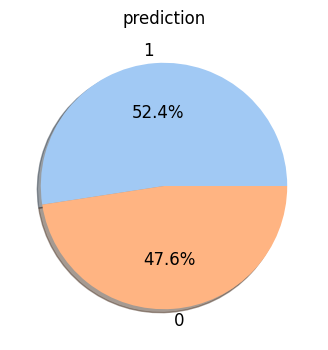

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
labels = df2['prediction'].unique()
ratio = df2[['prediction']].value_counts()
colors = sns.color_palette('pastel')[0:2]

fig = plt.figure(figsize=(5, 4))
plt.pie(ratio, labels=labels, autopct='%.1f%%', shadow=True, colors=colors, 
        textprops={'fontsize': 12})
plt.title('prediction')
plt.show()